## Обнаружение символов латинского алфавита

### Импортируем нужные библиотеки

In [ ]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from skimage.transform import resize
from sklearn import svm
from sklearn.model_selection import train_test_split
import sklearn.metrics as sk_metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

### Загрузка данных

In [ ]:
# Подключаем гугл диск для извлечение датасета о грибах
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


### Исследование данных

In [ ]:
# Загружаем датасет с drive
df = pd.read_csv('/content/drive/MyDrive/date/A_Z.csv')

In [ ]:
# Исследуем датасет
df.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.tail()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
372445,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372446,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372447,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372448,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372449,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


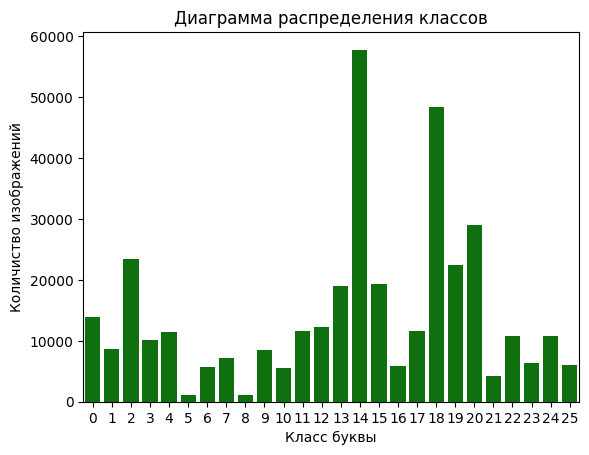

In [ ]:
# Построим диаграмму распределений изображений по классам
sns.countplot(x=df['0'], color='green');
plt.xlabel('Класс буквы')
plt.ylabel('Количиство изображений')
plt.title("Диаграмма распределения классов");

In [ ]:
# Разделим данные
# Признаки
X = df.iloc[:, 1:]
# Метки
Y = df.iloc[:, :1]

Классы сильно не сбалансированны, это в дальнейшем следует учесть

### Визуализация данных

In [ ]:
# Преобразуем данные в форму удобную для вывода
img = X.to_numpy().reshape(372450, 28, 28)
tag = Y.to_numpy()

In [ ]:
# Удостоверимся в том что форма изменилась
img.shape

(372450, 28, 28)

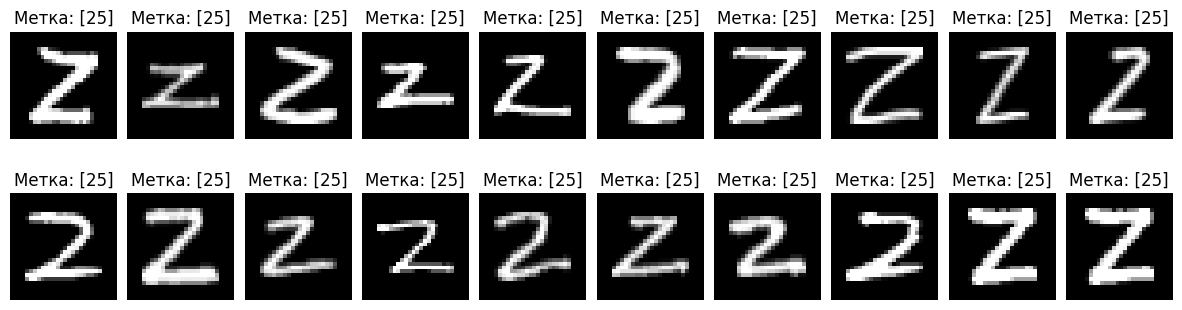

In [ ]:
# Демонстрация элементов датасета
plt.figure(figsize=(15,4))
for i in range(372430, 372450): # Выводим 20 последних изображений
    plt.subplot(2,10,i-372429)
    plt.axis('off')
    plt.imshow(img[i], cmap='gray') # отображение массива numpy как картинки; cmap - карта цветов, используем серую 'gray'
    plt.title(f"Метка: {tag[i]}")
    plt.subplots_adjust(hspace=.1, wspace=.1) # Отступы по ширине и высоте между картинками

### Взвешивание классов

Проблему несблансированности классов решим путем их взвешивания, маньшие классы будут иметь больший вес по сравнению с большими классами

In [ ]:
# Подготовим список меток
list_tag = list(Y['0'])

In [ ]:
# Произведем взвешивание классов
# На оснвоание списка меток получим веса каждой из них путем применения функции автовзвешивания
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(list_tag), y=list_tag)
# Создаим словарь весов
index = 0
dictionary_weight = dict()
for weight in class_weights:
  dictionary_weight[index] = weight
  index += 1

### Предобработка данных

In [ ]:
# Разделим данные на обучающие и тестовые наборы
X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=0.20, random_state=1, stratify=Y)

В целях ускорения обучения проиведем оптимизацию обучающих данных с помощью библиотеки PCA, путем выявления наиболее значимых признаков.

Бесплатная версия colab не позволяет произвести данную операцию на полной выборке, поэтому ее пришлось урезать, ввиду ограниченности в ресурсах вычислительных мощностей.

In [ ]:
# Вычислим количество компонентов РСА
# pca = PCA()
# pca.fit(X_train[:100000])
# cumsum = np.cumsum(pca.explained_variance_ratio_)
# d_95 = np.argmax(cumsum >= 0.95) + 1
# d_99 = np.argmax(cumsum >= 0.99) + 1
# print(f"Минимальное к-во компонентов для сохранения 95% дисперсий: {d_95}")
# print(f"Минимальное к-во компонентов для сохранения 99% дисперсий: {d_99}")

In [ ]:
# Наглядно продемонстрируем полученные выше данные, выбираются точки замедления динамики роста
# n_components = pca.explained_variance_ratio_.shape[0]
# plt.figure(figsize=(20,3))
# plt.plot(np.cumsum(pca.explained_variance_ratio_), color='green')
# plt.xticks(np.arange(0, n_components + 1, step=15))  # Устанавливаем шаг на оси X
# plt.xlabel('Количество компонентов')
# plt.ylabel('Объясненная дисперсия')
# plt.show()

In [ ]:
# Применение PCA для уменьшения размерности, рекомендуемый n_components=215
# pca = PCA(n_components=115)
# X_train = pca.fit_transform(X_train)
# X_test = pca.fit_transform(X_test)

### Инициализация и обучение модели машинного обучения

In [ ]:
C = 1.0
# model = svm.SVC(class_weight=dictionary_weight, kernel='linear', C=C)
# model = svm.LinearSVC(class_weight=dictionary_weight, C=C, max_iter=10000)
# model = svm.SVC(class_weight=dictionary_weight, kernel='rbf', gamma=0.1, C=C)

# Инициализиция модели с учетом весов классов
model = svm.SVC(class_weight=dictionary_weight, kernel='poly', degree=3, gamma=0.1, C=C)

In [ ]:
%%time
# Обучение модели
model = model.fit(X_train, Y_train.values.ravel())

CPU times: user 1h 9min 59s, sys: 12.7 s, total: 1h 10min 12s
Wall time: 1h 10min 59s


In [ ]:
%%time
# Проверка модели на тестовых данных
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

Точность accuracy на тренировчных данных: 100.0%
Точность accuracy на тестовых данных: 99.14350919586522%
CPU times: user 2h 46min 40s, sys: 16.2 s, total: 2h 46min 56s
Wall time: 2h 48min 9s


In [ ]:
# Расчет точности модели
accuracy_train = accuracy_score(y_pred_train, Y_train)
accuracy_test = accuracy_score(y_pred_test, Y_test)
print(f"Точность accuracy на тренировчных данных: {accuracy_train*100}%")
print(f"Точность accuracy: {accuracy_test*100}%")
# Рассчет точности precision
precision = precision_score(Y_test, y_pred_test, average=None)
print(f"Точность precision: {precision*100}")
# Рассчет полноты (recall)
recall = recall_score(Y_test, y_pred_test, average=None)
print(f"Полноты recall: {recall}")
# Рассчет F1-меры
f1 = f1_score(Y_test, y_pred_test, average=None)
print(f"F1-мера: {f1}")

Точность accuracy на тренировчных данных: 100.0%
Точность accuracy: 99.14350919586522%
Точность precision: [98.63896848 97.98154556 99.04478879 98.33251594 99.12126538 98.67256637
 98.33770779 97.91231733 96.03524229 98.40801887 97.23953695 99.35539321
 98.77899878 99.13272011 99.65430818 99.45694337 98.27139153 98.74458874
 99.67978515 99.57768393 99.4486561  99.27623643 99.11627907 99.19871795
 98.39670179 99.41569282]
Полноты recall: [0.99279019 0.97981546 0.99658266 0.98914652 0.98601399 0.95708155
 0.97569444 0.97437673 0.97321429 0.98234255 0.97413024 0.99784204
 0.98378597 0.99210942 0.9970601  0.99431231 0.97848537 0.98616515
 0.99648905 0.99577684 0.99500086 0.98444976 0.98794622 0.98724083
 0.98895028 0.98024691]
F1-мера: [0.98957959 0.97981546 0.9935058  0.98622725 0.98860649 0.97167756
 0.9795207  0.97674419 0.96674058 0.9832106  0.97326203 0.99569337
 0.98578392 0.99171815 0.99680152 0.99444085 0.98059508 0.9868051
 0.99664343 0.99577684 0.99474364 0.98858859 0.98955189 0.

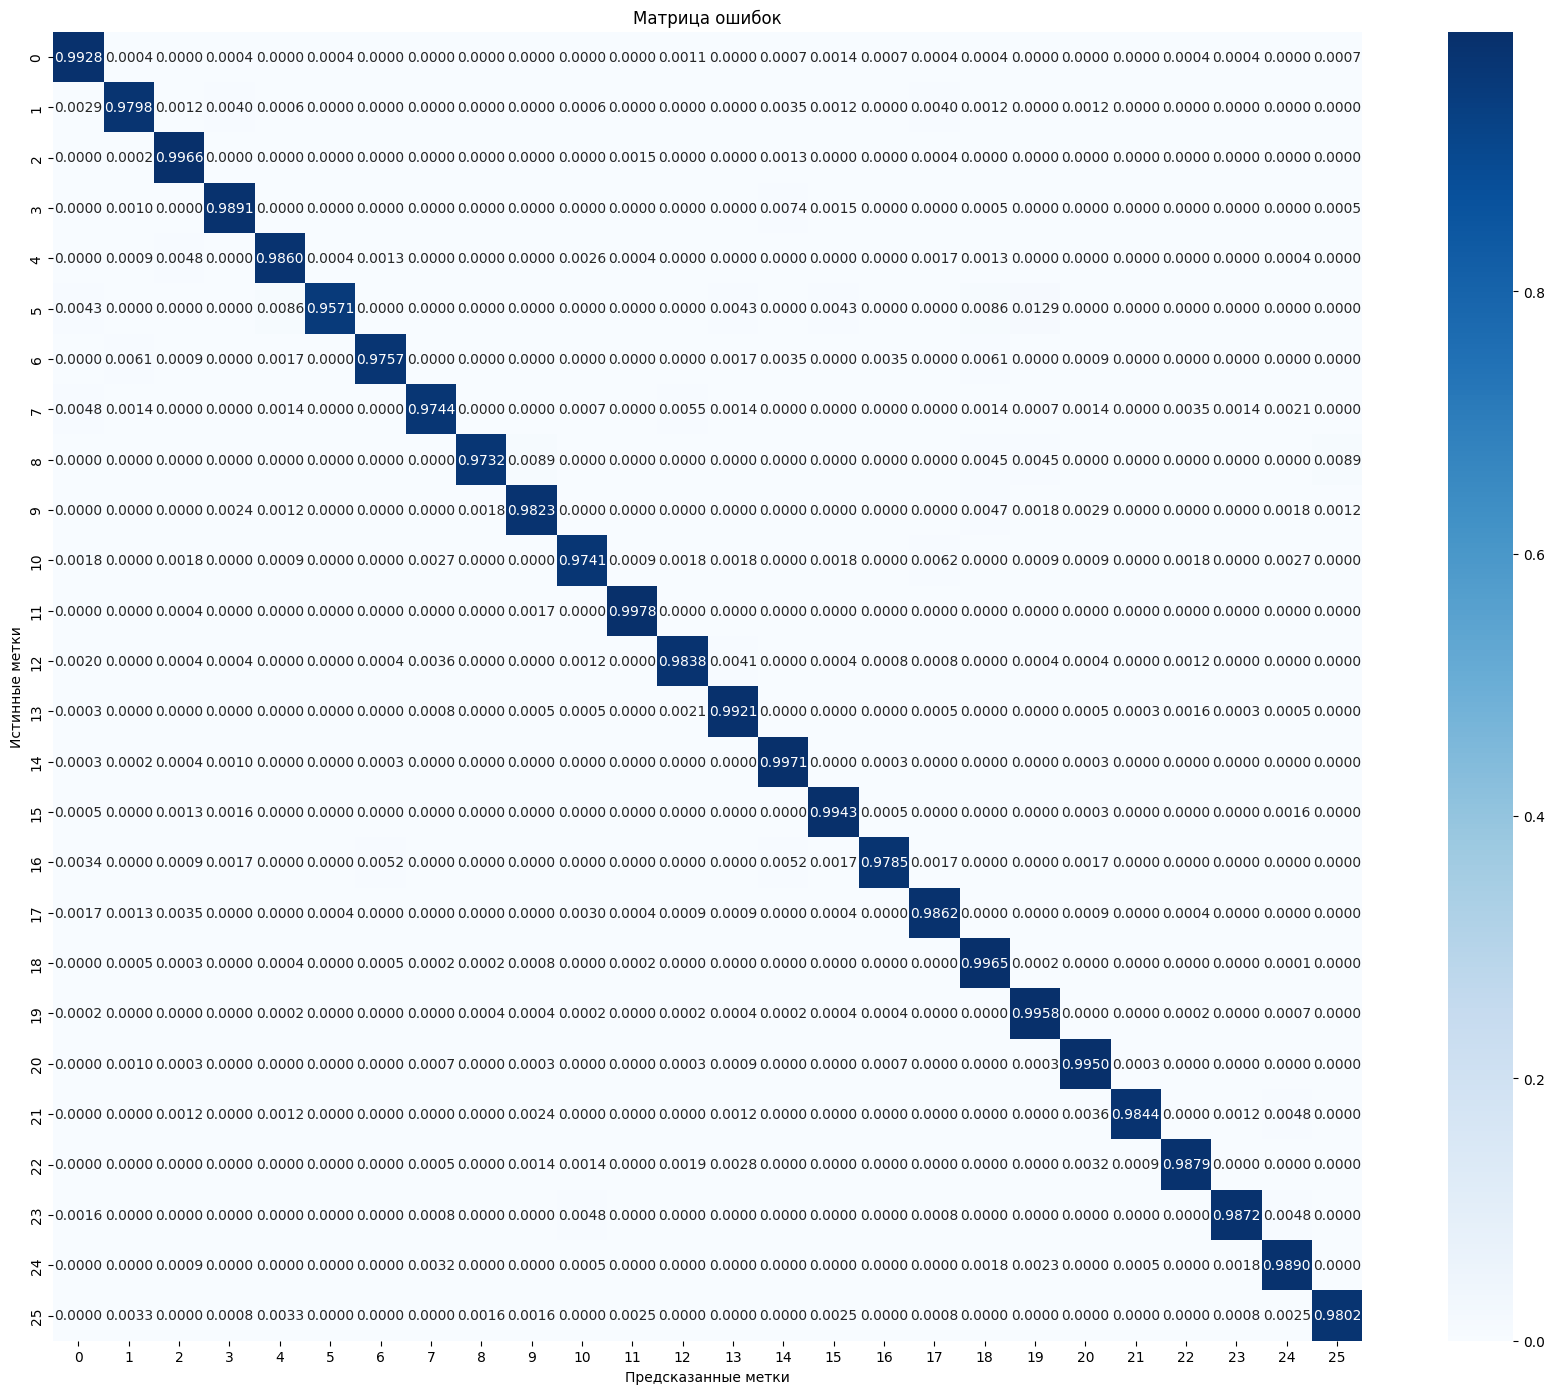

In [ ]:
# Построим матрицу ошибок
def show_confusion_matrix(test_labels, test_classes):
  # Вычисление матрицы ошибок и ее нормализация на обучающей выборке
  plt.figure(figsize=(22,17))
  confusion = sk_metrics.confusion_matrix(test_labels,
                                          test_classes)
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = range(26)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Матрица ошибок")
  plt.ylabel("Истинные метки")
  plt.xlabel("Предсказанные метки")

show_confusion_matrix(Y_test, y_pred_test)

Рекомендовано применять модель без методов сжатия. Точность на тестовой выборке без сжатия составила более 99%. Сжатие в разы ускоряет обучение модели, но приходиться жертвовать качеством распознания.